# # Ghana Maize Yield Prediction - Data Cleaning & Preprocessing
#
# ## Objective
# This notebook performs comprehensive data cleaning and preprocessing:
# - Handle missing values
# - Remove duplicates
# - Detect and handle outliers
# - Encode categorical variables
# - Scale numerical features
# - Create train/validation/test splits
# - Save processed data for modeling

# ## 1. Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
import json
from datetime import datetime

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the raw dataset
data_path = Path('../data/raw/Maize_dataset.csv')
df_raw = pd.read_csv(data_path)

print(f"Dataset loaded successfully!")
print(f"Original Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")

# Create a copy for processing
df = df_raw.copy()

Dataset loaded successfully!
Original Shape: 1,775 rows × 12 columns


# ## 2. Initial Data Inspection

In [3]:
# Display basic information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nData types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head()

DATASET OVERVIEW
Shape: (1775, 12)
Memory usage: 0.35 MB

Data types:
District          object
Year               int64
Yield            float64
Rainfall         float64
Temperature      float64
Humidity         float64
Sunlight         float64
Soil_Moisture    float64
Soil_Type         object
Pest_Risk          int64
PFJ_Policy         int64
Yield_Lag1       float64
dtype: object

First few rows:


,District,Year,Yield,Rainfall,Temperature,Humidity,Sunlight,Soil_Moisture,Soil_Type,Pest_Risk,PFJ_Policy,Yield_Lag1
0,A.M.A,2011,1.53,670.85,25.852745,87.471373,15.939739,0.827974,Coastal Savannah,0,0,1.00
1,A.M.A,2012,1.85,683.60,25.591503,86.877582,16.625163,0.814248,Coastal Savannah,0,0,1.53
2,A.M.A,2013,1.80,481.38,25.802222,85.133856,16.894248,0.761242,Coastal Savannah,0,0,1.85
3,A.M.A,2014,1.34,596.92,26.129346,85.771699,16.374771,0.782484,Coastal Savannah,0,0,1.80
4,A.M.A,2015,1.30,516.07,26.004052,86.899477,16.843137,0.793595,Coastal Savannah,0,0,1.34


# ## 3. Missing Values Analysis and Treatment

In [4]:
# Check for missing values
print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_summary) > 0:
    print("Missing values found:")
    print(missing_summary.to_string(index=False))
    
    # Visualize missing values
    if len(missing_summary) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.barh(missing_summary['Column'], missing_summary['Missing_Percentage'])
        ax.set_xlabel('Missing Percentage (%)')
        ax.set_title('Missing Values by Column')
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
else:
    print("No missing values found!")

MISSING VALUES ANALYSIS
No missing values found!


In [5]:
# Handle missing values
# Strategy: 
# - For numerical: Use median imputation by District
# - For categorical: Use mode imputation
# - For Yield_Lag1: Use forward fill within each district

missing_before = df.isnull().sum().sum()

if missing_before > 0:
    print("\nHandling missing values...")
    
    # Handle Yield_Lag1 specifically (use forward fill within district)
    if 'Yield_Lag1' in df.columns and df['Yield_Lag1'].isnull().any():
        df = df.sort_values(['District', 'Year'])
        df['Yield_Lag1'] = df.groupby('District')['Yield_Lag1'].fillna(method='ffill')
        print(f"  - Filled Yield_Lag1 using forward fill within districts")
    
    # Handle other numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numerical_cols:
        if df[col].isnull().any():
            df[col] = df.groupby('District')[col].transform(lambda x: x.fillna(x.median()))
            print(f"  - Filled {col} using district-level median")
    
    # Handle categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mode()[0])
            print(f"  - Filled {col} using mode")
    
    missing_after = df.isnull().sum().sum()
    print(f"\nMissing values: {missing_before} → {missing_after}")
else:
    print("\nNo missing values to handle")


No missing values to handle


# ## 4. Duplicate Detection and Removal

In [6]:
# Check for exact duplicates
print("=" * 80)
print("DUPLICATE DETECTION")
print("=" * 80)

duplicates_exact = df.duplicated().sum()
print(f"Exact duplicate rows: {duplicates_exact}")

if duplicates_exact > 0:
    print("\nRemoving exact duplicates...")
    df = df.drop_duplicates()
    print(f"Removed {duplicates_exact} duplicate rows")

# Check for District-Year duplicates
district_year_duplicates = df.duplicated(subset=['District', 'Year']).sum()
print(f"\nDuplicate District-Year combinations: {district_year_duplicates}")

if district_year_duplicates > 0:
    print("\nFound duplicate District-Year combinations:")
    duplicate_rows = df[df.duplicated(subset=['District', 'Year'], keep=False)].sort_values(['District', 'Year'])
    print(duplicate_rows[['District', 'Year', 'Yield']].head(20))
    
    # Strategy: Keep the first occurrence
    print("\nRemoving duplicate District-Year combinations (keeping first)...")
    df = df.drop_duplicates(subset=['District', 'Year'], keep='first')
    print(f"Removed {district_year_duplicates} duplicate District-Year combinations")

print(f"\nShape after duplicate removal: {df.shape}")

DUPLICATE DETECTION
Exact duplicate rows: 0

Duplicate District-Year combinations: 1

Found duplicate District-Year combinations:
        District  Year  Yield
1108  Kwahu West  2011    2.2
1109  Kwahu West  2011    2.1

Removing duplicate District-Year combinations (keeping first)...
Removed 1 duplicate District-Year combinations

Shape after duplicate removal: (1774, 12)


# ## 5. Outlier Detection and Treatment

In [7]:
# Outlier detection using IQR method
print("=" * 80)
print("OUTLIER DETECTION AND TREATMENT")
print("=" * 80)

def detect_outliers_iqr(data, column, multiplier=1.5):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    return outliers, lower_bound, upper_bound

# Features to check for outliers
features_to_check = ['Yield', 'Rainfall', 'Temperature', 'Humidity', 'Sunlight', 'Soil_Moisture']

outlier_summary = []
outlier_indices = set()

for feature in features_to_check:
    outliers, lower, upper = detect_outliers_iqr(df, feature)
    n_outliers = outliers.sum()
    
    outlier_summary.append({
        'Feature': feature,
        'Outliers': n_outliers,
        'Percentage': f"{(n_outliers / len(df) * 100):.2f}%",
        'Lower_Bound': f"{lower:.2f}",
        'Upper_Bound': f"{upper:.2f}",
        'Min': f"{df[feature].min():.2f}",
        'Max': f"{df[feature].max():.2f}"
    })
    
    outlier_indices.update(df[outliers].index.tolist())

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

print(f"\nTotal unique rows with outliers: {len(outlier_indices)}")

OUTLIER DETECTION AND TREATMENT
      Feature  Outliers Percentage Lower_Bound Upper_Bound    Min     Max
        Yield         3      0.17%        0.33        3.85   0.27    3.97
     Rainfall        13      0.73%      368.99     1110.50 369.81 1229.97
  Temperature         3      0.17%       23.30       29.12  24.39   29.48
     Humidity        17      0.96%       67.20       98.69  61.82   90.38
     Sunlight         4      0.23%       14.12       20.39  14.92   20.92
Soil_Moisture         0      0.00%        0.37        0.94   0.45    0.87

Total unique rows with outliers: 37


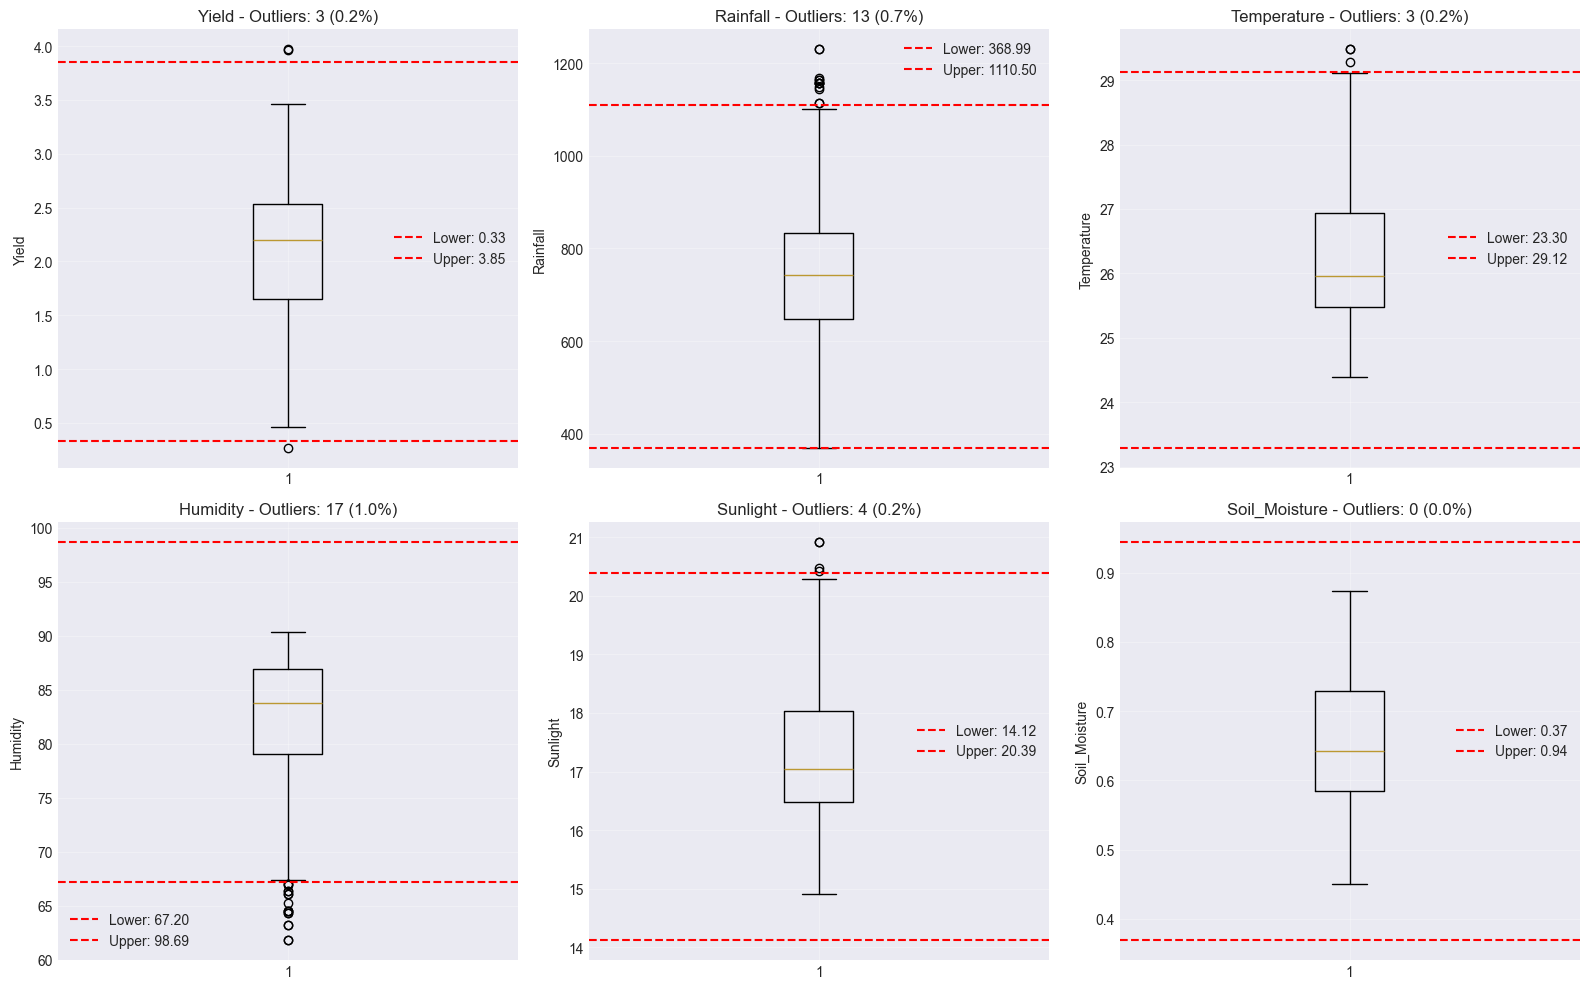

In [8]:
# Visualize outliers
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_check):
    outliers, lower, upper = detect_outliers_iqr(df, feature)
    
    axes[idx].boxplot(df[feature], vert=True)
    axes[idx].axhline(lower, color='r', linestyle='--', label=f'Lower: {lower:.2f}')
    axes[idx].axhline(upper, color='r', linestyle='--', label=f'Upper: {upper:.2f}')
    axes[idx].set_ylabel(feature)
    axes[idx].set_title(f'{feature} - Outliers: {outliers.sum()} ({(outliers.sum()/len(df)*100):.1f}%)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# Outlier treatment strategy
print("\nOutlier Treatment Strategy:")
print("Cap outliers at bounds (conservative)")
print("Capping outliers at IQR bounds")

# Cap outliers
for feature in features_to_check:
    outliers, lower, upper = detect_outliers_iqr(df, feature)
    
    if outliers.sum() > 0:
        # Cap at lower bound
        df.loc[df[feature] < lower, feature] = lower
        # Cap at upper bound
        df.loc[df[feature] > upper, feature] = upper
        print(f"  ✓ Capped {feature}: {outliers.sum()} outliers")

print(f"\nOutlier treatment complete!")
print(f"Shape after outlier treatment: {df.shape}")


Outlier Treatment Strategy:
Cap outliers at bounds (conservative)
Capping outliers at IQR bounds

Outlier treatment complete!
Shape after outlier treatment: (1774, 12)


# ## 6. Feature Engineering

In [13]:
print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Create interaction features
print("\nCreating interaction features...")

# 1. Growing Degree Days (temperature * sunlight)
df['Growing_Degree_Days'] = df['Temperature'] * df['Sunlight']
print("  ✓ Created: Growing_Degree_Days (Temperature × Sunlight)")

# 2. Water Availability Index (rainfall * soil_moisture)
df['Water_Availability'] = df['Rainfall'] * df['Soil_Moisture']
print("  ✓ Created: Water_Availability (Rainfall × Soil_Moisture)")

# 3. Climate Stress Index (temperature / humidity)
df['Climate_Stress'] = df['Temperature'] / (df['Humidity'] + 1)  # +1 to avoid division by zero
print("  ✓ Created: Climate_Stress (Temperature / Humidity)")

# 4. Moisture-Temperature Ratio
df['Moisture_Temp_Ratio'] = df['Soil_Moisture'] / (df['Temperature'] + 1)
print("  ✓ Created: Moisture_Temp_Ratio")

# 5. Rainfall per Sunlight Hour
df['Rainfall_per_Sun'] = df['Rainfall'] / (df['Sunlight'] + 1)
print("  ✓ Created: Rainfall_per_Sun")

# 6. Years since PFJ start (2017)
df['Years_Since_PFJ'] = df.apply(lambda row: max(0, row['Year'] - 2017) if row['PFJ_Policy'] == 1 else 0, axis=1)
print("  ✓ Created: Years_Since_PFJ")

# 7. Yield Change (current - lag)
df['Yield_Change'] = df['Yield'] - df['Yield_Lag1']
print("  ✓ Created: Yield_Change")

# 8. Yield Growth Rate
df['Yield_Growth_Rate'] = (df['Yield'] - df['Yield_Lag1']) / (df['Yield_Lag1'] + 0.001)
print("  ✓ Created: Yield_Growth_Rate")

print(f"\nFeature engineering complete! New features: 8")
print(f"Current shape: {df.shape}")

FEATURE ENGINEERING

Creating interaction features...
  ✓ Created: Growing_Degree_Days (Temperature × Sunlight)
  ✓ Created: Water_Availability (Rainfall × Soil_Moisture)
  ✓ Created: Climate_Stress (Temperature / Humidity)
  ✓ Created: Moisture_Temp_Ratio
  ✓ Created: Rainfall_per_Sun
  ✓ Created: Years_Since_PFJ
  ✓ Created: Yield_Change
  ✓ Created: Yield_Growth_Rate

Feature engineering complete! New features: 8
Current shape: (1774, 20)


# ## 7. Categorical Encoding

In [16]:
print("=" * 80)
print("CATEGORICAL ENCODING")
print("=" * 80)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns: {categorical_cols}")

# Create encoders dictionary
encoders = {}

# 1. Label Encoding for ordinal/binary categories
# (We'll use one-hot encoding for District and Soil_Type in the modeling phase)

# 2. Store categorical mappings for reference
print("\nCategorical Value Counts:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    
# 3. For now, we'll keep categorical columns as-is
# They will be encoded during model training based on the algorithm used

print("\nCategorical encoding prepared!")
print("   Note: District and Soil_Type will be encoded during model training")

CATEGORICAL ENCODING

Categorical columns: ['District', 'Soil_Type']

Categorical Value Counts:

District:
District
Kwahu West             12
A.M.A                  11
Dangme East            11
Nadowli                11
Mfantsiman             11
                       ..
Pusiga                  5
Dangme West             5
Nandom                  5
Binduri                 5
Dafiama Bussie Issa     5
Name: count, Length: 182, dtype: int64

Soil_Type:
Soil_Type
Forest Ochrosol         1046
Savanna Ochrosol         424
Tropical Black Earth     204
Coastal Savannah         100
Name: count, dtype: int64

Categorical encoding prepared!
   Note: District and Soil_Type will be encoded during model training


# ## 8. Feature Scaling

In [17]:
print("=" * 80)
print("FEATURE SCALING")
print("=" * 80)

# Identify numerical features to scale (exclude target and IDs)
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude target and ID-like columns
columns_to_exclude = ['Yield', 'Year']
features_to_scale = [col for col in numerical_features if col not in columns_to_exclude]

print(f"\nFeatures to scale ({len(features_to_scale)}):")
for i, col in enumerate(features_to_scale, 1):
    print(f"  {i}. {col}")

# Note: We'll save the unscaled version for now
# Scaling will be done after train/test split to prevent data leakage
print("\nFeature scaling will be applied after train/test split")

FEATURE SCALING

Features to scale (16):
  1. Rainfall
  2. Temperature
  3. Humidity
  4. Sunlight
  5. Soil_Moisture
  6. Pest_Risk
  7. PFJ_Policy
  8. Yield_Lag1
  9. Growing_Degree_Days
  10. Water_Availability
  11. Climate_Stress
  12. Moisture_Temp_Ratio
  13. Rainfall_per_Sun
  14. Years_Since_PFJ
  15. Yield_Change
  16. Yield_Growth_Rate

Feature scaling will be applied after train/test split


# ## 9. Train/Validation/Test Split

In [18]:
print("=" * 80)
print("TRAIN/VALIDATION/TEST SPLIT")
print("=" * 80)

# Sort by year to ensure temporal ordering
df = df.sort_values(['Year', 'District']).reset_index(drop=True)

# Strategy: Time-based split to respect temporal nature
# - Training: 2011-2018 (8 years)
# - Validation: 2019-2020 (2 years)
# - Test: 2021 (1 year)

train_years = df['Year'] <= 2018
val_years = (df['Year'] >= 2019) & (df['Year'] <= 2020)
test_years = df['Year'] == 2021

train_df = df[train_years].copy()
val_df = df[val_years].copy()
test_df = df[test_years].copy()

print(f"\nDataset Split Summary:")
print(f"  Training Set (2011-2018):   {len(train_df):,} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation Set (2019-2020): {len(val_df):,} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test Set (2021):            {len(test_df):,} samples ({len(test_df)/len(df)*100:.1f}%)")
print(f"  Total:                      {len(df):,} samples")

# Verify no data leakage
print(f"\nData Leakage Check:")
print(f"  Max year in training:   {train_df['Year'].max()}")
print(f"  Min year in validation: {val_df['Year'].min()}")
print(f"  Max year in validation: {val_df['Year'].max()}")
print(f"  Min year in test:       {test_df['Year'].min()}")

TRAIN/VALIDATION/TEST SPLIT

Dataset Split Summary:
  Training Set (2011-2018):   1,228 samples (69.2%)
  Validation Set (2019-2020): 364 samples (20.5%)
  Test Set (2021):            182 samples (10.3%)
  Total:                      1,774 samples

Data Leakage Check:
  Max year in training:   2018
  Min year in validation: 2019
  Max year in validation: 2020
  Min year in test:       2021


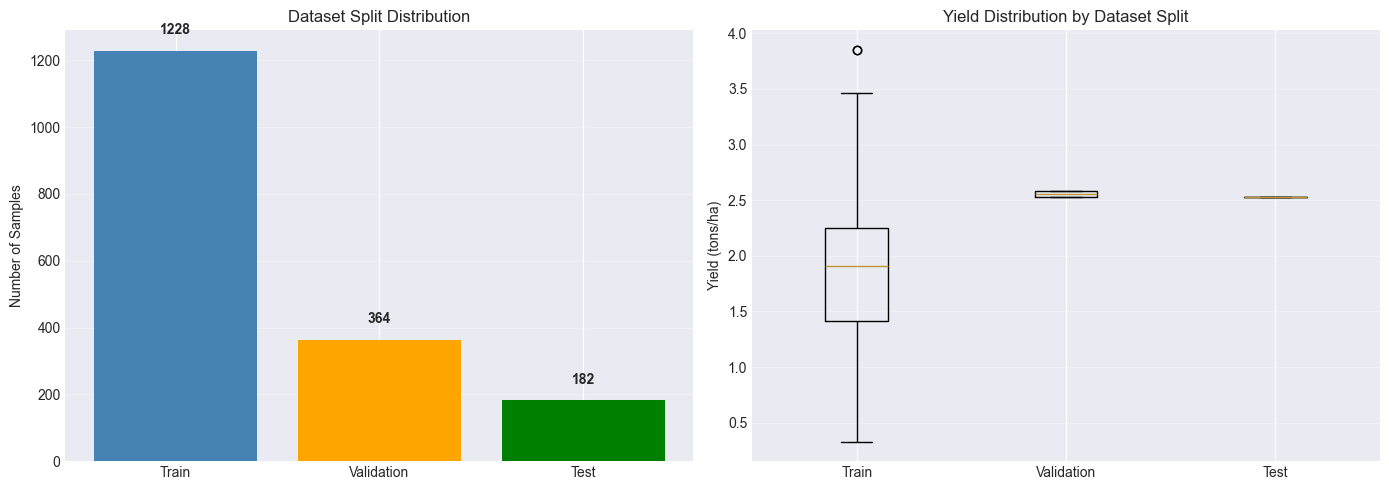

In [19]:
# Visualize split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sample distribution
split_counts = pd.Series({
    'Train': len(train_df),
    'Validation': len(val_df),
    'Test': len(test_df)
})
axes[0].bar(split_counts.index, split_counts.values, color=['steelblue', 'orange', 'green'])
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Dataset Split Distribution')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(split_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Yield distribution by split
axes[1].boxplot([train_df['Yield'], val_df['Yield'], test_df['Yield']], 
                labels=['Train', 'Validation', 'Test'])
axes[1].set_ylabel('Yield (tons/ha)')
axes[1].set_title('Yield Distribution by Dataset Split')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ## 10. Apply Feature Scaling

In [21]:
print("=" * 80)
print("APPLYING FEATURE SCALING")
print("=" * 80)

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data only
scaler.fit(train_df[features_to_scale])

# Transform all splits
train_df_scaled = train_df.copy()
val_df_scaled = val_df.copy()
test_df_scaled = test_df.copy()

train_df_scaled[features_to_scale] = scaler.transform(train_df[features_to_scale])
val_df_scaled[features_to_scale] = scaler.transform(val_df[features_to_scale])
test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

print("Feature scaling applied!")
print(f"\nScaled features: {len(features_to_scale)}")
print(f"  Mean (train): {train_df_scaled[features_to_scale].mean().mean():.6f}")
print(f"  Std (train):  {train_df_scaled[features_to_scale].std().mean():.6f}")

APPLYING FEATURE SCALING
Feature scaling applied!

Scaled features: 16
  Mean (train): -0.000000
  Std (train):  1.000407


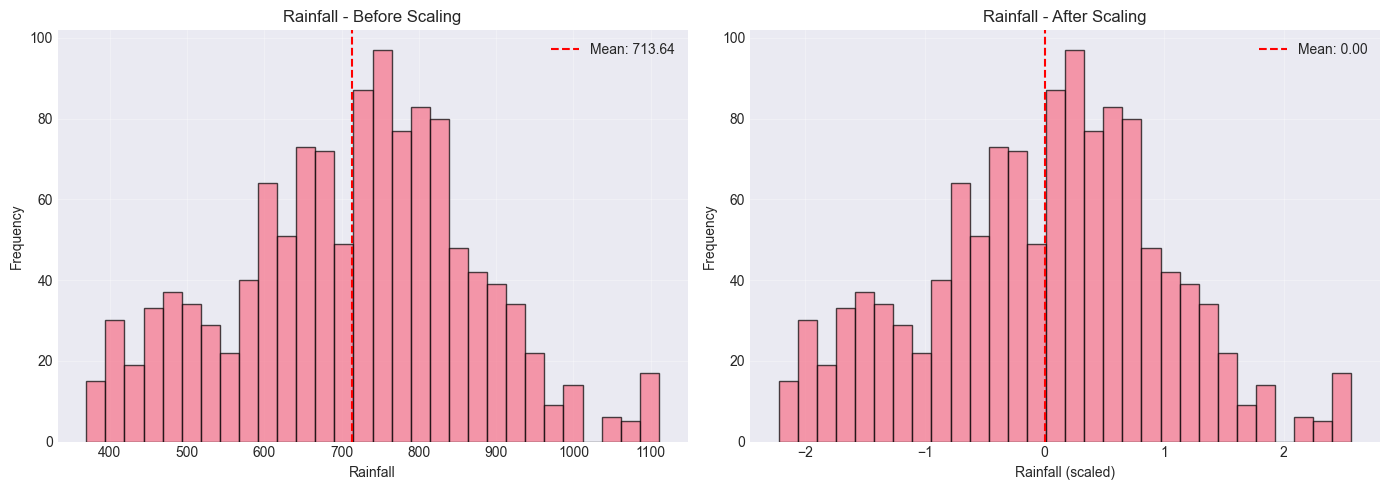

In [22]:
# Compare before and after scaling (sample feature)
sample_feature = features_to_scale[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
axes[0].hist(train_df[sample_feature], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel(sample_feature)
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'{sample_feature} - Before Scaling')
axes[0].axvline(train_df[sample_feature].mean(), color='r', linestyle='--', 
               label=f'Mean: {train_df[sample_feature].mean():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After scaling
axes[1].hist(train_df_scaled[sample_feature], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel(f'{sample_feature} (scaled)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'{sample_feature} - After Scaling')
axes[1].axvline(train_df_scaled[sample_feature].mean(), color='r', linestyle='--', 
               label=f'Mean: {train_df_scaled[sample_feature].mean():.2f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ## 11. Save Processed Data

In [23]:
print("=" * 80)
print("SAVING PROCESSED DATA")
print("=" * 80)

# Create processed data directory if it doesn't exist
processed_dir = Path('../data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)

# Save unscaled versions (for interpretability)
train_df.to_csv(processed_dir / 'train.csv', index=False)
val_df.to_csv(processed_dir / 'validation.csv', index=False)
test_df.to_csv(processed_dir / 'test.csv', index=False)

print("Unscaled data saved:")
print(f"  - {processed_dir / 'train.csv'}")
print(f"  - {processed_dir / 'validation.csv'}")
print(f"  - {processed_dir / 'test.csv'}")

# Save scaled versions (for modeling)
train_df_scaled.to_csv(processed_dir / 'train_scaled.csv', index=False)
val_df_scaled.to_csv(processed_dir / 'validation_scaled.csv', index=False)
test_df_scaled.to_csv(processed_dir / 'test_scaled.csv', index=False)

print("\nScaled data saved:")
print(f"  - {processed_dir / 'train_scaled.csv'}")
print(f"  - {processed_dir / 'validation_scaled.csv'}")
print(f"  - {processed_dir / 'test_scaled.csv'}")

# Save full processed dataset (before split)
df.to_csv(processed_dir / 'maize_data_processed.csv', index=False)
print(f"\nFull processed dataset saved:")
print(f"  - {processed_dir / 'maize_data_processed.csv'}")

SAVING PROCESSED DATA
Unscaled data saved:
  - ..\data\processed\train.csv
  - ..\data\processed\validation.csv
  - ..\data\processed\test.csv

Scaled data saved:
  - ..\data\processed\train_scaled.csv
  - ..\data\processed\validation_scaled.csv
  - ..\data\processed\test_scaled.csv

Full processed dataset saved:
  - ..\data\processed\maize_data_processed.csv


# ## 12. Save Preprocessing Artifacts

In [25]:
print("=" * 80)
print("SAVING PREPROCESSING ARTIFACTS")
print("=" * 80)

# Save scaler
import joblib
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

# Helper: convert numpy / pandas types to native Python types
def to_python_type(obj):
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    if isinstance(obj, (pd.Index,)):
        return obj.tolist()
    if isinstance(obj, tuple):
        return tuple(to_python_type(x) for x in obj)
    return obj


# Directories
artifacts_dir = Path('../models/trained')
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Save scaler
joblib.dump(scaler, artifacts_dir / 'scaler.pkl')
print(f"✅ Scaler saved: {artifacts_dir / 'scaler.pkl'}")

# Preprocessing metadata
preprocessing_log = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'original_shape': to_python_type(df_raw.shape),
    'processed_shape': to_python_type(df.shape),
    'missing_values_handled': to_python_type(missing_before),
    'duplicates_removed': to_python_type(duplicates_exact + district_year_duplicates),
    'outliers_capped': to_python_type(len(outlier_indices)),
    'features_engineered': 8,
    'features_scaled': to_python_type(features_to_scale),
    'train_size': to_python_type(len(train_df)),
    'val_size': to_python_type(len(val_df)),
    'test_size': to_python_type(len(test_df)),
    'train_years': '2011-2018',
    'val_years': '2019-2020',
    'test_years': '2021',
    'columns': df.columns.tolist()
}

# Save preprocessing log
log_path = processed_dir / 'preprocessing_log.json'
with open(log_path, 'w') as f:
    json.dump(preprocessing_log, f, indent=4)

print(f"✅ Preprocessing log saved: {log_path}")


SAVING PREPROCESSING ARTIFACTS
✅ Scaler saved: ..\models\trained\scaler.pkl
✅ Preprocessing log saved: ..\data\processed\preprocessing_log.json


# ## 13. Data Quality Report

In [28]:
print("=" * 80)
print("DATA QUALITY REPORT")
print("=" * 80)

report = f"""
📊 DATA PREPROCESSING SUMMARY
{'=' * 80}

ORIGINAL DATASET:
  - Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns
  - Time Period: {df_raw['Year'].min()} - {df_raw['Year'].max()}
  - Districts: {df_raw['District'].nunique()}

CLEANING OPERATIONS:
  ✓ Missing values handled: {missing_before}
  ✓ Duplicates removed: {duplicates_exact + district_year_duplicates}
  ✓ Outliers capped: {len(outlier_indices)}

FEATURE ENGINEERING:
  ✓ New features created: 8
  ✓ Total features: {df.shape[1]}

PROCESSED DATASET:
  - Shape: {df.shape[0]:,} rows × {df.shape[1]} columns
  - Features scaled: {len(features_to_scale)}

TRAIN/VAL/TEST SPLIT:
  - Training:   {len(train_df):,} samples (2011-2018) - {len(train_df)/len(df)*100:.1f}%
  - Validation: {len(val_df):,} samples (2019-2020) - {len(val_df)/len(df)*100:.1f}%
  - Test:       {len(test_df):,} samples (2021)      - {len(test_df)/len(df)*100:.1f}%

TARGET VARIABLE (Yield):
  Training Set:
    - Mean: {train_df['Yield'].mean():.3f} tons/ha
    - Std:  {train_df['Yield'].std():.3f} tons/ha
    - Range: [{train_df['Yield'].min():.3f}, {train_df['Yield'].max():.3f}]
  
  Validation Set:
    - Mean: {val_df['Yield'].mean():.3f} tons/ha
    - Std:  {val_df['Yield'].std():.3f} tons/ha
    - Range: [{val_df['Yield'].min():.3f}, {val_df['Yield'].max():.3f}]
  
  Test Set:
    - Mean: {test_df['Yield'].mean():.3f} tons/ha
    - Std:  {test_df['Yield'].std():.3f} tons/ha
    - Range: [{test_df['Yield'].min():.3f}, {test_df['Yield'].max():.3f}]

FILES SAVED:
  ✓ Unscaled data: train.csv, validation.csv, test.csv
  ✓ Scaled data: train_scaled.csv, validation_scaled.csv, test_scaled.csv
  ✓ Full dataset: maize_data_processed.csv
  ✓ Scaler: scaler.pkl
  ✓ Preprocessing log: preprocessing_log.json

{'=' * 80}
✅ DATA PREPROCESSING COMPLETE!
{'=' * 80}

NEXT STEPS:
  1. Review the processed data quality
  2. Proceed to feature engineering notebook (optional)
  3. Begin model training with train.csv
  4. Validate models with validation.csv
  5. Final evaluation with test.csv

"""

print(report)

# Save report
report_path = processed_dir / 'data_quality_report.txt'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"📄 Report saved: {report_path}")


DATA QUALITY REPORT

📊 DATA PREPROCESSING SUMMARY

ORIGINAL DATASET:
  - Shape: 1,775 rows × 12 columns
  - Time Period: 2010 - 2021
  - Districts: 182

CLEANING OPERATIONS:
  ✓ Missing values handled: 0
  ✓ Duplicates removed: 1
  ✓ Outliers capped: 37

FEATURE ENGINEERING:
  ✓ New features created: 8
  ✓ Total features: 20

PROCESSED DATASET:
  - Shape: 1,774 rows × 20 columns
  - Features scaled: 16

TRAIN/VAL/TEST SPLIT:
  - Training:   1,228 samples (2011-2018) - 69.2%
  - Validation: 364 samples (2019-2020) - 20.5%
  - Test:       182 samples (2021)      - 10.3%

TARGET VARIABLE (Yield):
  Training Set:
    - Mean: 1.832 tons/ha
    - Std:  0.490 tons/ha
    - Range: [0.330, 3.850]
  
  Validation Set:
    - Mean: 2.555 tons/ha
    - Std:  0.025 tons/ha
    - Range: [2.530, 2.580]
  
  Test Set:
    - Mean: 2.530 tons/ha
    - Std:  0.000 tons/ha
    - Range: [2.530, 2.530]

FILES SAVED:
  ✓ Unscaled data: train.csv, validation.csv, test.csv
  ✓ Scaled data: train_scaled.csv, val